## Tide Table for Cape Lookout

In [1]:
# Imports
import requests as req
import datetime
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
# Get today's date
today = datetime.date.today()
query_date = str(today).replace('-', '')

In [3]:
# Get the data
url = "https://tidesandcurrents.noaa.gov/api/datagetter?begin_date={}&end_date={}&station=8656841&product=predictions&datum=MLLW&time_zone=lst&units=english&format=json".format(query_date, query_date)
noaa_response = req.get(url)  # Response object 
data = noaa_response.json()  # To json 

for prediction in data['predictions'][0:10]:
    print(prediction)

{'t': '2019-08-30 00:00', 'v': '0.044'}
{'t': '2019-08-30 00:06', 'v': '0.017'}
{'t': '2019-08-30 00:12', 'v': '-0.004'}
{'t': '2019-08-30 00:18', 'v': '-0.019'}
{'t': '2019-08-30 00:24', 'v': '-0.027'}
{'t': '2019-08-30 00:30', 'v': '-0.029'}
{'t': '2019-08-30 00:36', 'v': '-0.026'}
{'t': '2019-08-30 00:42', 'v': '-0.016'}
{'t': '2019-08-30 00:48', 'v': '-0.001'}
{'t': '2019-08-30 00:54', 'v': '0.021'}


In [4]:
# Create Pandas DataFrame
tide_predictions = pd.DataFrame.from_dict(data['predictions'])
tide_predictions.head()

,t,v
0,2019-08-30 00:00,0.044
1,2019-08-30 00:06,0.017
2,2019-08-30 00:12,-0.004
3,2019-08-30 00:18,-0.019
4,2019-08-30 00:24,-0.027


In [5]:
tide_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
t    240 non-null object
v    240 non-null object
dtypes: object(2)
memory usage: 3.8+ KB


In [6]:
# Rename columns and change data types 
tide_predictions.columns = ['Hour', 'Height']
tide_predictions['Hour']=tide_predictions['Hour'].str[-5:-3].astype(int) + (tide_predictions['Hour'].str[-2:].astype(int))/60
tide_predictions['Height']=tide_predictions['Height'].astype(float)
tide_predictions.sort_values('Hour')
tide_predictions.head()

,Hour,Height
0,0.0,0.044
1,0.1,0.017
2,0.2,-0.004
3,0.3,-0.019
4,0.4,-0.027


In [7]:
tide_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
Hour      240 non-null float64
Height    240 non-null float64
dtypes: float64(2)
memory usage: 3.8 KB


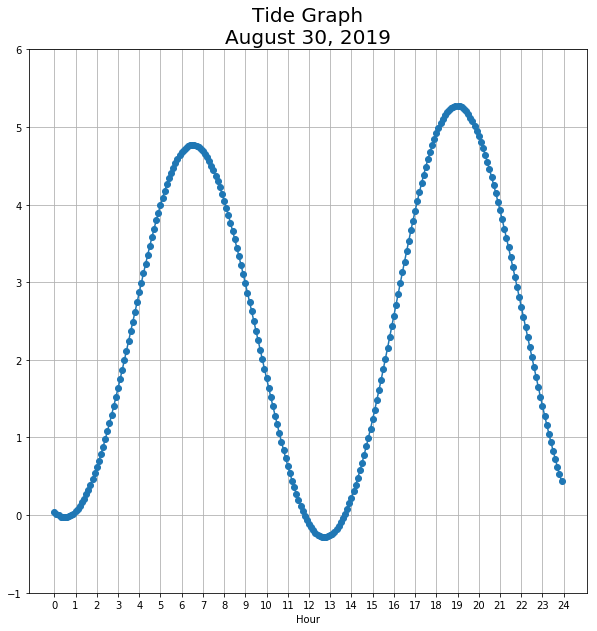

In [8]:
%matplotlib inline 
plt.figure(figsize=(10, 10))
plt.plot(tide_predictions['Hour'], tide_predictions['Height'], marker='o')
plt.ylim(-1, 6)
plt.title("Tide Graph\n{:%B %d, %Y}".format(today), fontsize=20)
plt.grid(axis='both')
plt.xticks(range(0, 25))
plt.xlabel('Hour')
plt.show()

In [9]:
# Calculate times for high and low tides. 

def max_tide(series):
    """Returns list of indices for which 'height' is a relative maximum."""
    maxima = []
    for i in range(238):
        if series.iloc[i] <= series.iloc[i+1] and series.iloc[i+1] >= series.iloc[i+2]:
            maxima.append(i+1)
    return maxima
        
            
def min_tide(series):
    """Returns list of indices for which 'height' is a relative minimum."""
    minima = []
    for i in range(238):
        if series.iloc[i] >= series.iloc[i+1] and series.iloc[i+1] <= series.iloc[i+2]:
            minima.append(i+1) 
    return minima


def hour_to_time(h):
    """Converts 'hours past midnight' to 'time of day'."""
    hour = int(h)
    minute = int(round((h - hour) * 60, 0))
    if minute == 0:
        minute = '00'
    if hour == 0:
        return str(12) + ':' + str(minute) + ' am'
    if hour < 12:
        return str(hour) + ':' + str(minute) + ' am'
    if hour == 12:
        return str(12) + ':' + str(minute) + ' pm'
    return str(hour % 12) + ':' + str(minute) + ' pm'


maxima = max_tide(tide_predictions['Height'])
minima = min_tide(tide_predictions['Height'])

high_tide = tide_predictions.iloc[maxima].copy()
high_tide.loc[:, 'Event'] = 'High Tide'

low_tide = tide_predictions.iloc[minima].copy() 
low_tide.loc[:, 'Event'] = 'Low Tide'

tide_table = pd.concat([high_tide, low_tide], ignore_index=True)

tide_table['Time'] = tide_table['Hour'].apply(hour_to_time)
tide_table = tide_table[['Time', 'Hour', 'Height', 'Event']]
tide_table.sort_values('Hour', inplace=True)
tide_table.index = [0, 1, 2, 3]
tide_table

,Time,Hour,Height,Event
0,12:30 am,0.5,-0.029,Low Tide
1,6:30 am,6.5,4.769,High Tide
2,12:42 pm,12.7,-0.284,Low Tide
3,7:00 pm,19.0,5.272,High Tide
